<a href="https://colab.research.google.com/github/abhay1432/TinyML/blob/main/3_3_7_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
tf_version = "2.19.0"
hub_version = "0.16.1"
datasets_version = "4.9.9"
numpy_version = "2.0.2"
protobuf_version = "3.20.3"

import tensorflow as tf
import numpy as np

try:
    import tensorflow_hub as hub
    import tensorflow_datasets as tfds
except:
    hub = None
    tfds = None

# Check if versions match
if (tf.__version__ != tf_version or
    (hub and hub.__version__ != hub_version) or
    (tfds and tfds.__version__ != datasets_version) or
    not np.__version__.startswith(numpy_version)):

    print(f"Current TensorFlow version: {tf.__version__} → {tf_version}")
    if hub: print(f"Current TensorFlow Hub version: {hub.__version__} → {hub_version}")
    if tfds: print(f"Current TensorFlow Datasets version: {tfds.__version__} → {datasets_version}")
    print(f"Current NumPy version: {np.__version__} → {numpy_version}")

    # Uninstall old versions
    !pip uninstall -y tensorflow tensorflow_hub tensorflow_datasets numpy protobuf

    # Install specific versions
    !pip install tensorflow=={tf_version} \
                tensorflow_hub=={hub_version} \
                tensorflow_datasets=={datasets_version} \
                numpy=={numpy_version} \
                protobuf=={protobuf_version}

    # Prompt user to restart
    print("\n Specified versions installed successfully.")
    print(" Please restart the runtime (Runtime > Restart session) and re-run the notebook.\n")
else:
    print(" All packages are already at the specified versions.")

 All packages are already at the specified versions.


In [10]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")


def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label


(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print(num_examples)
print(num_classes)

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

23262
2


TensorShape([32, 224, 224, 3])

In [11]:
# 1. Load the base model from Keras applications
base_model = tf.keras.applications.MobileNetV2(
input_shape=(224, 224, 3),
include_top=False,
weights='imagenet')
# 2. Freeze the base model
base_model.trainable = False
# 3. Create the new model on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), # This layer flattens the feature map
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 865s 1s/step - accuracy: 0.9537 - loss: 0.1112 - val_accuracy: 0.9811 - val_loss: 0.0503
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 814s 1s/step - accuracy: 0.9858 - loss: 0.0400 - val_accuracy: 0.9828 - val_loss: 0.0475
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 884s 1s/step - accuracy: 0.9872 - loss: 0.0382 - val_accuracy: 0.9824 - val_loss: 0.0495
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 888s 2s/step - accuracy: 0.9878 - loss: 0.0362 - val_accuracy: 0.9781 - val_loss: 0.0654
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 816s 1s/step - accuracy: 0.9888 - loss: 0.0355 - val_accuracy: 0.9828 - val_loss: 0.0571


In [13]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"
model.export(CATS_VS_DOGS_SAVED_MODEL)


Saved artifact at 'exp_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_312')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134352060687632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352060688400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352016096720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352060689168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352060686096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352016087120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352016095952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352016096144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352016096336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134352016094608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13435201609

In [14]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)
# This will report back the file size in bytes

8874680

In [15]:
from tqdm import tqdm
# Load TFLite model and allocate tensors.
tflite_model_file = '/tmp/model1.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))

    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


# This will tell you how many of the predictions were correct
score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
100%|██████████| 100/100 [00:01<00:00, 54.55it/s]

Out of 100 predictions I got 100 correct


In [16]:

#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

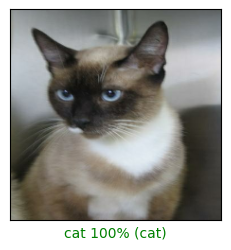

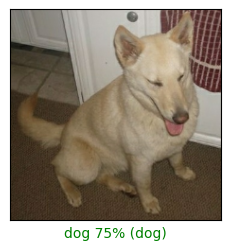

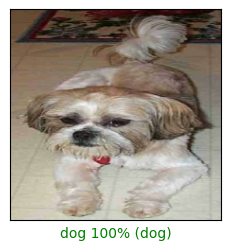

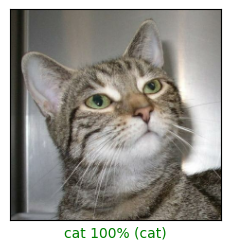

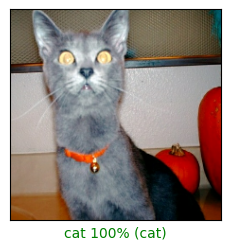

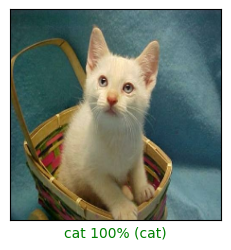

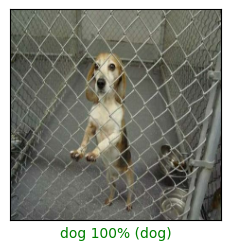

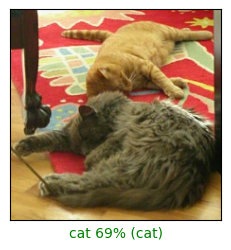

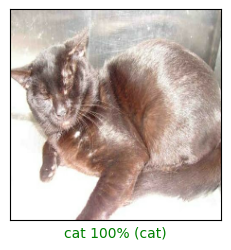

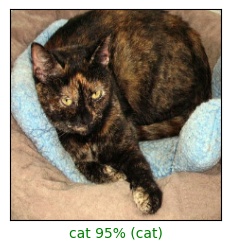

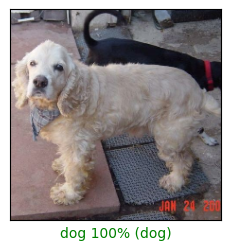

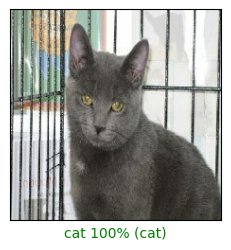

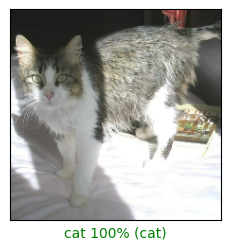

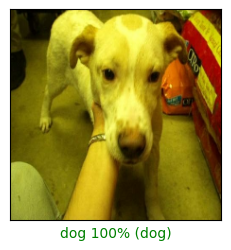

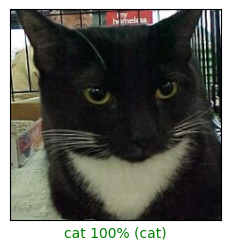

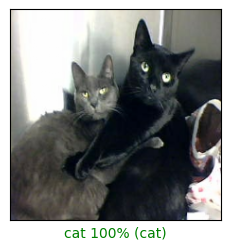

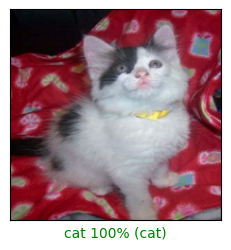

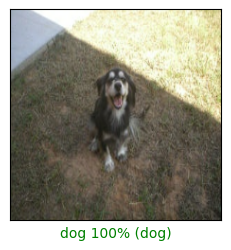

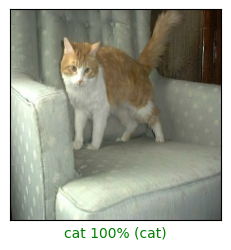

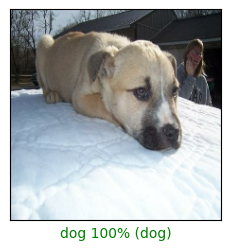

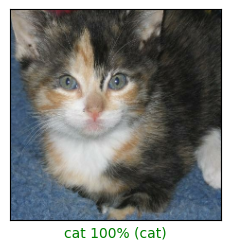

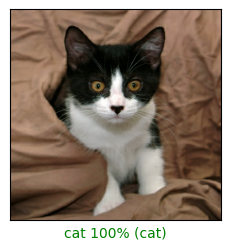

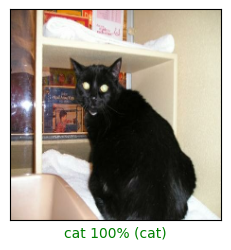

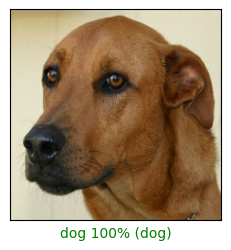

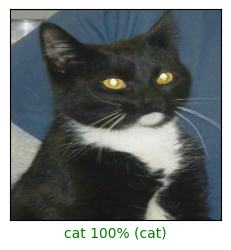

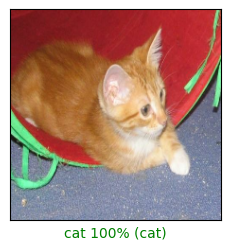

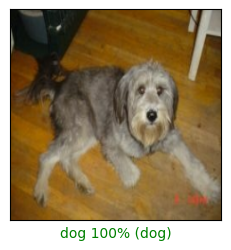

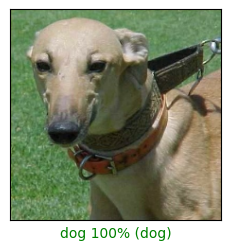

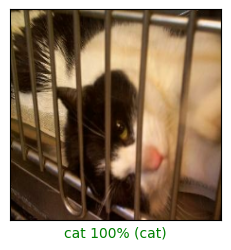

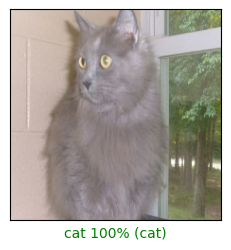

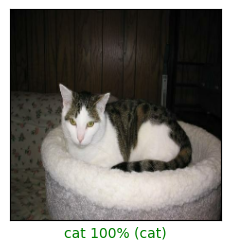

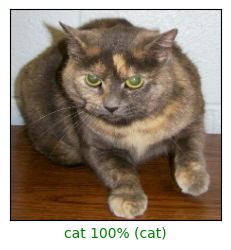

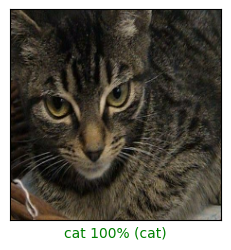

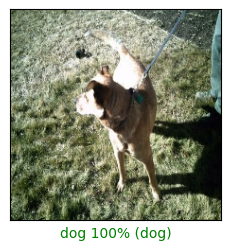

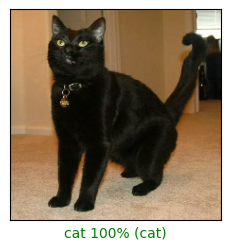

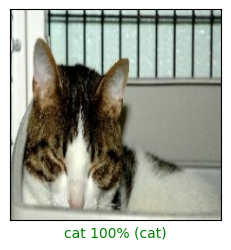

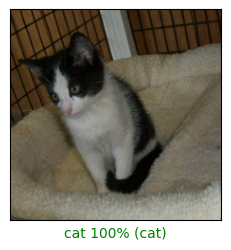

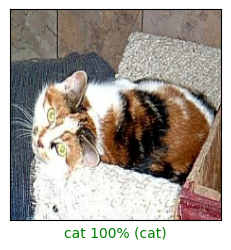

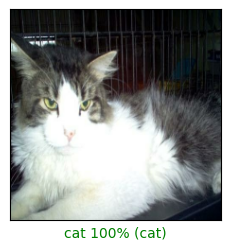

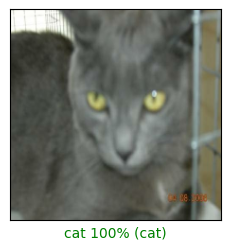

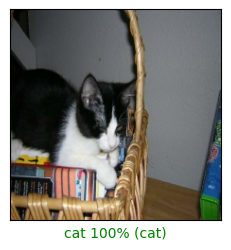

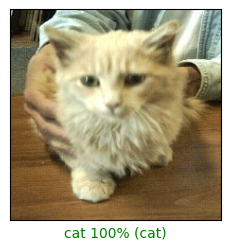

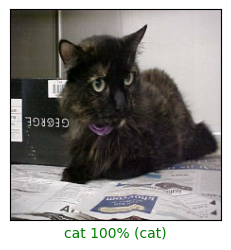

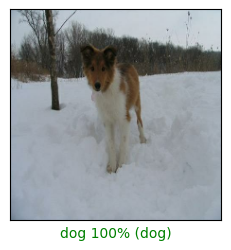

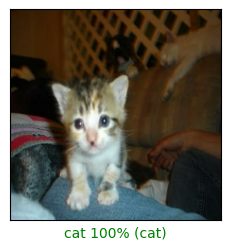

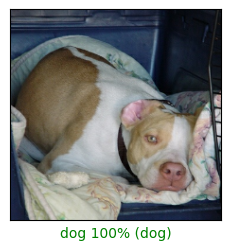

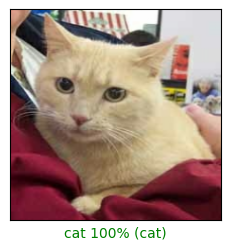

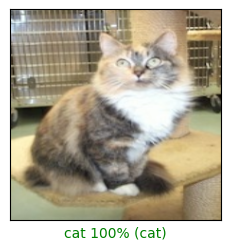

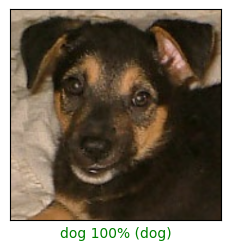

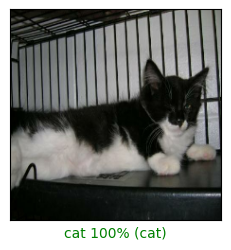

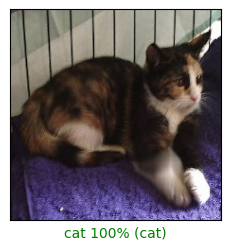

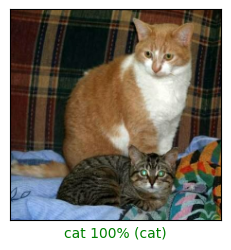

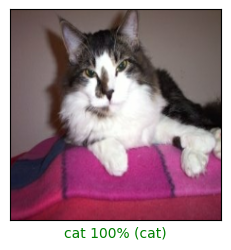

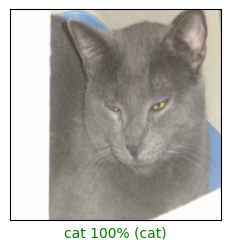

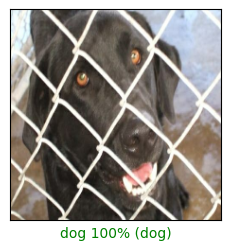

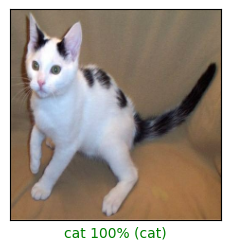

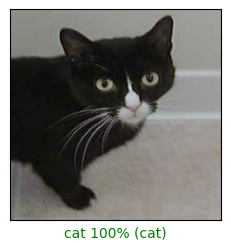

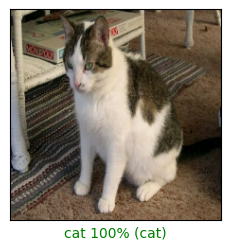

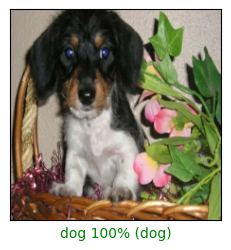

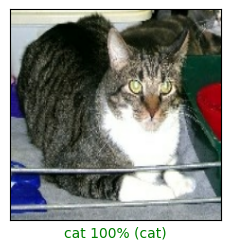

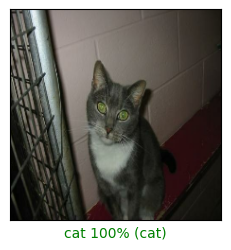

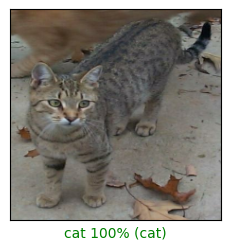

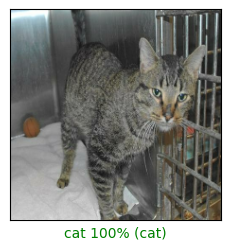

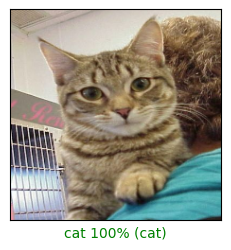

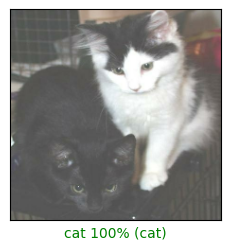

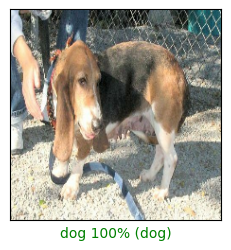

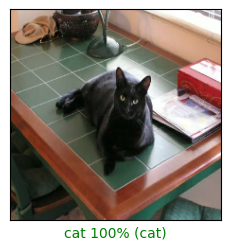

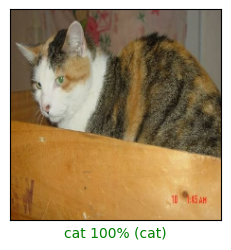

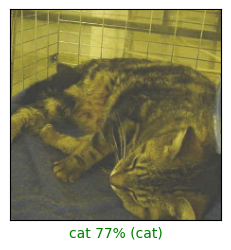

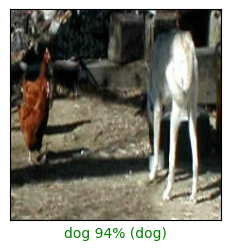

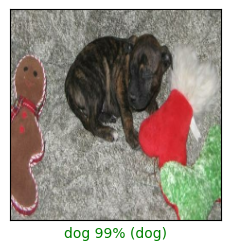

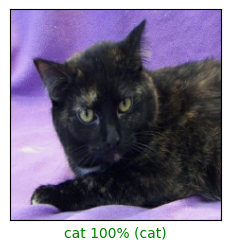

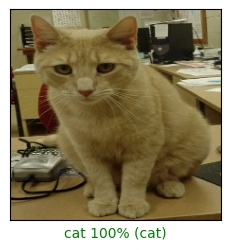

In [17]:
#@title Visualize the outputs { run: "auto" }
max_index = 73 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()